# Языковые модели

Корпус про страховые случаи взят у [Оли Дайховской.](https://github.com/odaykhovskaya/NLP-games) Кстати говоря, у Оли есть [отличный репозиторий с матерными словами](https://github.com/odaykhovskaya/obscene_words_ru/blob/master/obscene_corpus.txt) на все случаи жизни. Можно попробовать на них что-нибудь погенерировать.

## 1. Модели из NLTK 

In [9]:
from nltk import FreqDist, ConditionalFreqDist, ConditionalProbDist, MLEProbDist
from nltk import bigrams, trigrams

Берём корпус из названий динозавров.

In [1]:
pad = '_'  # для начала и конца слова

with open('./data/dinos.txt', 'r', encoding='utf-8') as f:
    data = f.readlines()
names = [pad+name.strip().lower()+pad for name in data]
names[:10]

['_aachenosaurus_',
 '_aardonyx_',
 '_abdallahsaurus_',
 '_abelisaurus_',
 '_abrictosaurus_',
 '_abrosaurus_',
 '_abydosaurus_',
 '_acanthopholis_',
 '_achelousaurus_',
 '_acheroraptor_']

In [10]:
len(names)

1536

Разбиваем все названия на токены. В нашем случае это будут буквы. Считаем частоты букв. 

In [11]:
chars = [char for name in names for char in name]
freq = FreqDist(chars)

print(list(freq.values()))

[3072, 2487, 539, 548, 913, 1081, 1710, 2285, 2123, 1704, 341, 266, 85, 171, 617, 944, 852, 552, 111, 328, 360, 37, 55, 141, 41, 60, 23]


Находим биграммы и их условные частоты.

In [12]:
cfreq = ConditionalFreqDist(bigrams(chars))
print(cfreq['a'])

<FreqDist with 27 samples and 2487 outcomes>


In [13]:
cprob = ConditionalProbDist(cfreq, MLEProbDist)
print('p(a|_) = %1.4f' %cprob['a'].prob('_'))
print('p(a|_) = %1.4f' %cprob['a'].prob('b'))
print('p(s|_) = %1.4f' %cprob['_'].prob('a'))

p(a|_) = 0.0555
p(a|_) = 0.0097
p(s|_) = 0.0541


Посчитаем вероятность встретить в корпусе конкретную букву по формуле полной вероятности. 

In [17]:
l = sum([freq[char] for char in freq])

def unigram_prob(char):
    return freq[char] / l

print('p(a) = %1.4f' %unigram_prob('a'))

p(a) = 0.1160


Можно сгеерировать новый символ, отталкиваясь от предыдущего.

In [18]:
cprob['u'].generate()

'l'

Напишем функцию для генерации нового имени динозавра! 

In [32]:
def f(word):
    new = cprob[word[-1]].generate()
    if new == '_':
        return word + new
    else:
        return word + new + f(new)

In [33]:
f('_')

'_aattaanneelllluurruussaarrss_'

## 2. Марковские цепи

[Репозиторий библиотечки](https://github.com/jsvine/markovify)

In [34]:
import pandas as pd
import numpy as np

from tqdm import tqdm_notebook
import re

import gensim

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [36]:
df = pd.read_excel('asn.xlsx', index_col=0)
df.head()

,review_text,tema,mark
0,"первое дтп в водительской карьере, первый опыт...",Автострахование,5
1,Уважаемые господа! Это был первый и последний ...,Автострахование,1
2,Мой отец Рогов Сергей Дмитриевич в 2014 году з...,Имущественное страхование,Без оценки
3,"Сломал кость на кисти руки в гололёд, была стр...",Личное страхование,Без оценки
4,Страховой полис КАСКО- № 79089/046/3494384/6. ...,Автострахование,1


In [37]:
df.shape

(20831, 3)

In [38]:
df.review_text.apply(len).describe()

count    20831.000000
mean      1031.860688
std       1005.525397
min         52.000000
25%        446.000000
50%        765.000000
75%       1271.000000
max      28057.000000
Name: review_text, dtype: float64

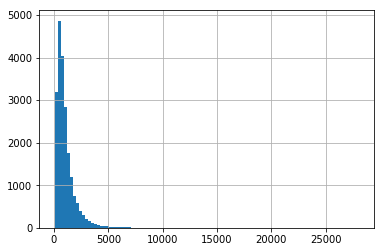

In [39]:
df.review_text.apply(len).hist(bins=100);

In [40]:
df.mark.value_counts()

1                            11105
5                             3147
Без оценки                    3125
2                             2004
3                              739
4                              711
Name: mark, dtype: int64

In [41]:
df.tema.value_counts()

Автострахование              18124
Личное страхование            1790
Имущественное страхование      916
Name: tema, dtype: int64

In [42]:
df.tema.value_counts()

Автострахование              18124
Личное страхование            1790
Имущественное страхование      916
Name: tema, dtype: int64

In [43]:
#pip install markovify
#Цепи Маркова
import markovify

In [44]:
text = df['review_text'].values

In [45]:
text[1500]

'Полис 566280. Хочу поблагодарить за быструю и квалифицированную помощь сотрудников медицинского центра «Капитал-полис» и лично кардиолога Е.М.Парфенову. При обращении в поликлинику Центра я был быстро обследован, госпитализирован на машине «скорой помощи» в кардиологическое отделение Городской Покровской больницы, где уже на следующий день мне была сделана операция. Условия содержания в больнице были хорошими, сотрудники «Капитал-полиса» интересовались качестом оказываемой медицнской помощи. В настоящее время успешно прохожу реабилитацию в санатории «Черная речка».'

In [46]:
text = ' '.join(text)
len(text)

21515520

In [47]:
#Запилить модель
text_model = markovify.Text(text)

In [74]:
text_model.make_sentence()

'В этом году продляла полис и поставьте галочку.'

In [54]:
# Нксколько рандомных предложений
for i in range(5):
    print(text_model.make_sentence())

Все работники с кем то из представителей страховой компании, посчитали мне сумму ущерба в гражданско-правовом порядке, покольку противоправные действия третих лиц и руководящего состава данной СК.
Срок рассмотрения поставили 10 рабочих дней произвести выплату страхового возмещения в размере 900 рублей.
Не стал с ними все в лучшем случае получу 500 рублей за то, что можно согласовывать столько времени, сколько потребуется.
Надо подовать в суд.
Всем огромный привет и наилучшие пожелания в бескомпромиссной борьбе с этими циниками, так как много информации, что собственником автомобиля или в Центральный офис «Росгосстрах», где нам сообщили, что решение будет принято какое-либо решение.


In [59]:
# Несколько рандомных предложений длины не боле чем 140 символов
for i in range(3):
    print(text_model.make_short_sentence(140))

А в офисе мне нахамили и сказали вам позвонят.
Вменяемое отношение к работе… как будто я не получила, я работаю в Нижнем Новгороде, пришел в офис страховой компании отвечают.
Сфотографировали царапину и вот теперь очень жалею, что оформила Осаго на авто без проблем.


In [60]:
# Начиня с какого-то слова!
for i in range(3):
    print(text_model.make_sentence_with_start('Беспредел'))

Беспредел полный и подробный.
Беспредел полный и обширный перечень документов, которые нужно предоставить.
Беспредел полный и подробный.


In [70]:
# Начиня с какого-то слова!
for i in range(3):
    print(text_model.make_sentence_with_start('Хамло'))

Хамло и быдло самое настоящее!!! Ни какой реакции не произошло.
Хамло и быдло самое настоящее!!! Ни какой культуры!!! Приобрели мобильный телефон, застраховала его в юротделе ЖЭУ, после чего компания считает, что это и поборы за страхование автобусов агентам не выплачивают уже больше месяца.
Хамло и быдло самое настоящее!!! Ни какой реакции не произошло, такую справку «надо бы как-то получить от них это самое мое в кавычках моя история не закончена я в очереди на Графском пер.


In [68]:
# Начиня с какого-то слова!
for i in range(3):
    print(text_model.make_sentence_with_start('___BEGIN__'))

А машина всё еще не открыта запись.
Ну что ж, пишу жалобу в Службу Банка России который отозвал лицензию СО «Купеческое и не был прописан пункт «ремонт по направлению»? если «ремонт по направлению» находится за тридевять земель, терять документы, разводить волокиту и нервотрепку?
02 мая у меня произошла беда, у нас все время один и тот же.


In [71]:
# Начиня с какого-то слова!
for i in range(3):
    print(text_model.make_sentence_with_start('очень'))

очень много кто остался без всякой конетели получил страховую выплату с ОАО «АльфаСтрахованием» — судебные расходы и нет и срок рассмотрения у них по закону и условиям подошла компания «ВСК». Удобным условием было оформление полиса Осаго ВВВ0641256165 Не секрет, что рубль дешевеет, выплаты не было, все вовремя.
очень хорошее отношение к людям унизительное.
очень не плохо выбрать страховую.


То же самое, но на триграммах.

In [72]:
text_model_3 = markovify.Text(text, state_size=3)

In [73]:
for i in range(3):
    print(text_model_3.make_short_sentence(140))

Вот скажите может быть у человека сахарный диабет, либо еще что-то похуже, по причине чего и опоздала к назначенному времени.
Мне пришлось совершить звонок в головной офис с жалобой на задержку выплаты.
Так как машину уже забрали из ремонта могу сказать, что она показала полную некомпетентность в вопросе выплат и страховании в принципе.


# 3. Нейросетки (LSTM) 

In [75]:
import nltk
from nltk.corpus import treebank
# Import HMM module
from nltk.tag import hmm


train_sents = treebank.tagged_sents()
treebank_sents = treebank.tagged_sents()
train_sents = treebank.tagged_sents()[:int(0.9 * len(treebank_sents))]
test_sents = treebank.tagged_sents()[int(0.9 * len(treebank_sents)):]


# Setup a trainer with default(None) values
# And train with the data
trainer = hmm.HiddenMarkovModelTrainer()
tagger = trainer.train_supervised(train_sents)

print(tagger.evaluate(test_sents))

0.4255470737913486


In [76]:
tagger.tag()

<HiddenMarkovModelTagger 46 states and 12408 output symbols>

In [77]:
test_sents

[[('Kalamazoo', 'NNP'), (',', ','), ('Mich.-based', 'JJ'), ('First', 'NNP'), ('of', 'IN'), ('America', 'NNP'), ('said', 'VBD'), ('0', '-NONE-'), ('it', 'PRP'), ('will', 'MD'), ('eliminate', 'VB'), ('the', 'DT'), ('13', 'CD'), ('management', 'NN'), ('positions', 'NNS'), ('of', 'IN'), ('the', 'DT'), ('former', 'JJ'), ('Midwest', 'NNP'), ('Financial', 'NNP'), ('parent', 'NN'), ('company', 'NN'), ('.', '.')], [('First', 'NNP'), ('of', 'IN'), ('America', 'NNP'), ('said', 'VBD'), ('0', '-NONE-'), ('some', 'DT'), ('of', 'IN'), ('the', 'DT'), ('managers', 'NNS'), ('will', 'MD'), ('take', 'VB'), ('other', 'JJ'), ('jobs', 'NNS'), ('with', 'IN'), ('First', 'NNP'), ('of', 'IN'), ('America', 'NNP'), ('.', '.')], ...]

In [78]:
train_sents

[[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')], [('Mr.', 'NNP'), ('Vinken', 'NNP'), ('is', 'VBZ'), ('chairman', 'NN'), ('of', 'IN'), ('Elsevier', 'NNP'), ('N.V.', 'NNP'), (',', ','), ('the', 'DT'), ('Dutch', 'NNP'), ('publishing', 'VBG'), ('group', 'NN'), ('.', '.')], ...]